
Data Loaded: (82332, 45)
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2 

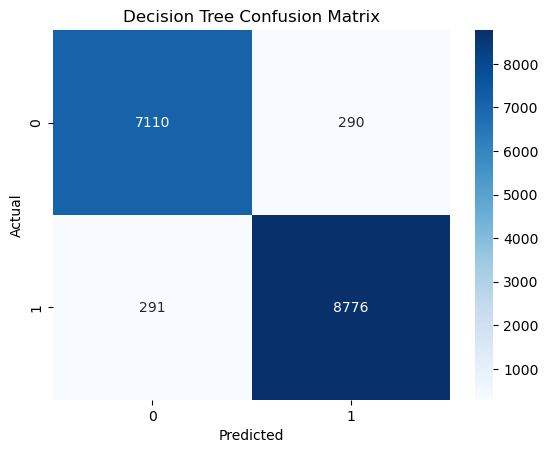


-
Running Random Forest...
-

Random Forest Metrics:
 {'Accuracy': 0.9758911762919779, 'F1': 0.9779896878638354, 'AUC': 0.9971931477082023}


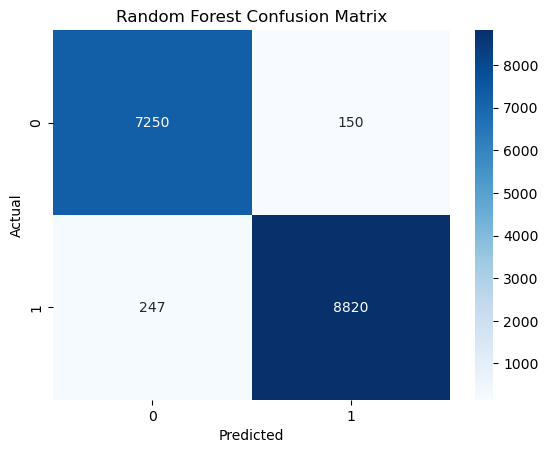


-
Running Extra Trees...
-

Extra Trees Metrics:
 {'Accuracy': 0.9745551709479565, 'F1': 0.9768213752281906, 'AUC': 0.9970348963720531}


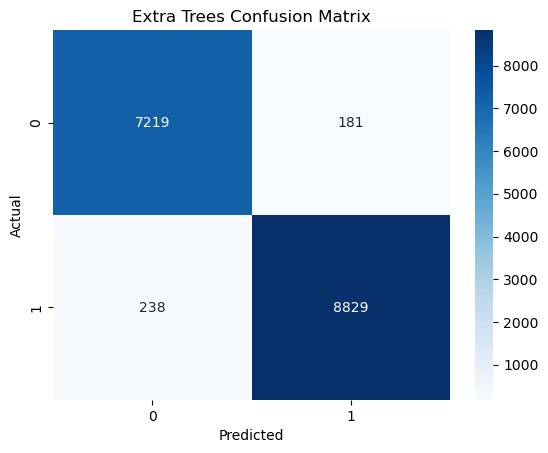


-
Running GBM...
-

GBM Metrics:
 {'Accuracy': 0.9639885832270602, 'F1': 0.9672212702448731, 'AUC': 0.994437066105479}


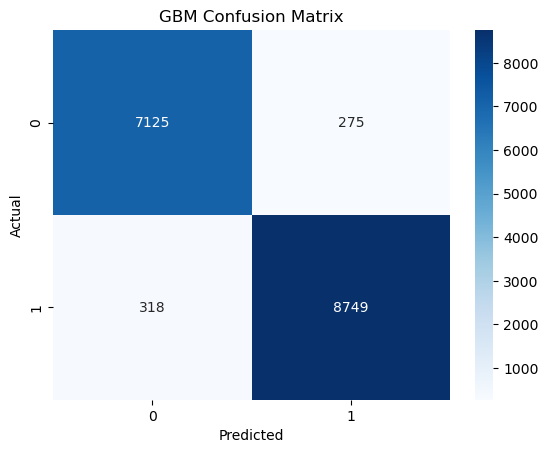


-
Running XGBoost...
-


C:\Users\acezi\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:39:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Metrics:
 {'Accuracy': 0.9788668245582073, 'F1': 0.980705256154358, 'AUC': 0.9978983483317884}


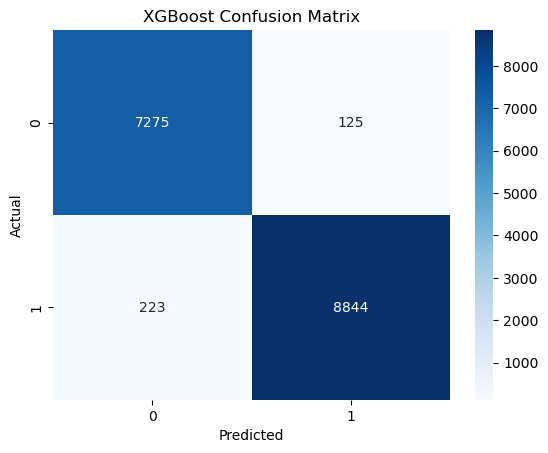


-
Running LightGBM...
-
[LightGBM] [Info] Number of positive: 36265, number of negative: 29600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5779
[LightGBM] [Info] Number of data points in the train set: 65865, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550596 -> initscore=0.203079
[LightGBM] [Info] Start training from score 0.203079

LightGBM Metrics:
 {'Accuracy': 0.9772879091516367, 'F1': 0.9792590949423248, 'AUC': 0.9978733467668617}


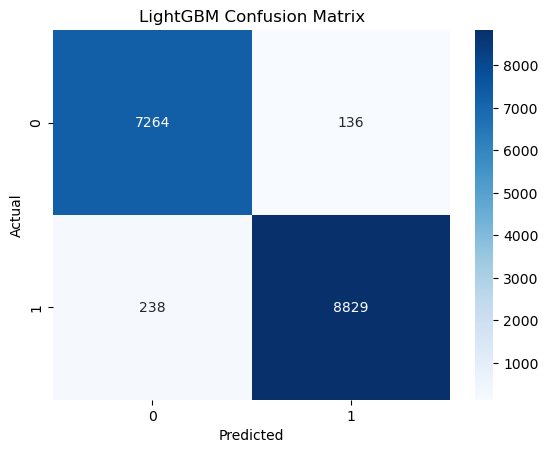


-
Running CatBoost...
-

CatBoost Metrics:
 {'Accuracy': 0.9754660836825165, 'F1': 0.9775779775779776, 'AUC': 0.9973447518324545}


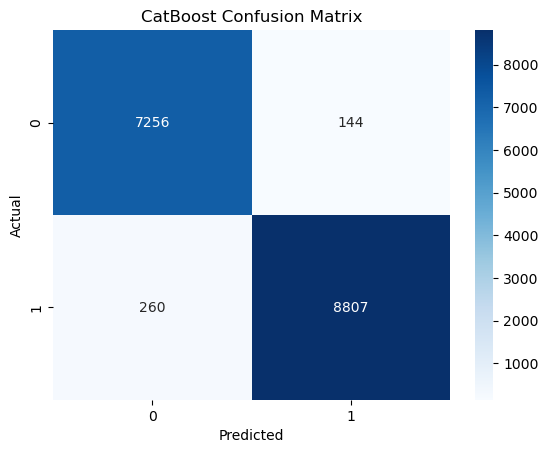



- Summary of Model Results -
               Accuracy      F1     AUC
Decision Tree    0.9647  0.9680  0.9644
Random Forest    0.9759  0.9780  0.9972
Extra Trees      0.9746  0.9768  0.9970
GBM              0.9640  0.9672  0.9944
XGBoost          0.9789  0.9807  0.9979
LightGBM         0.9773  0.9793  0.9979
CatBoost         0.9755  0.9776  0.9973


<Figure size 1000x500 with 0 Axes>

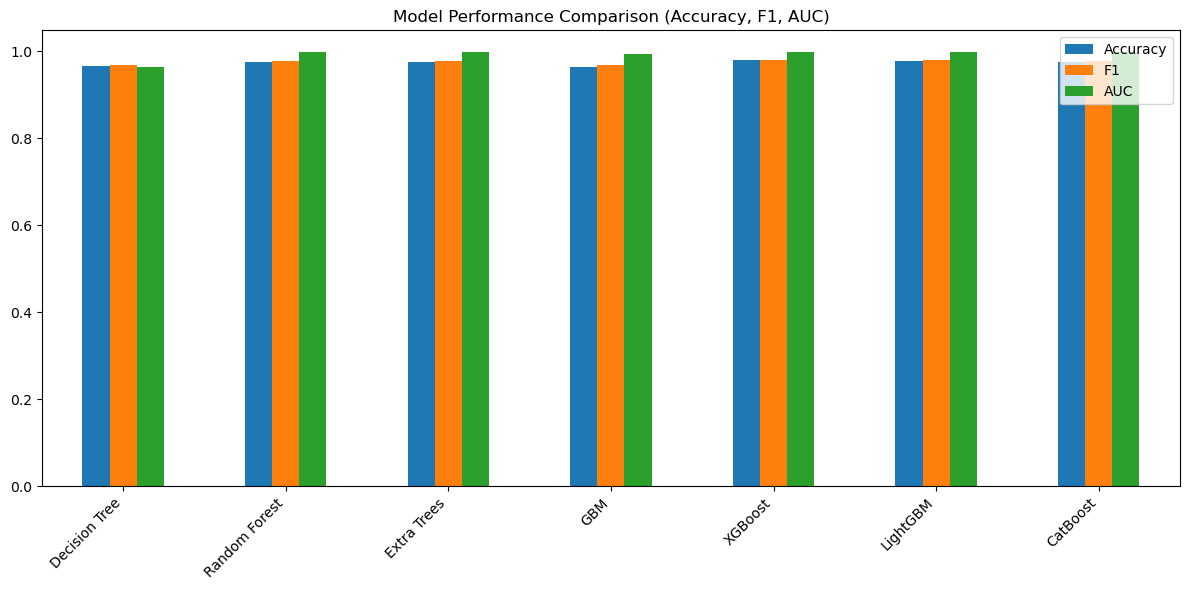

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def metrics(y_true, y_pred, y_prob=None):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob if y_prob is not None else y_pred)
    }

def plot_confusion(y_true, y_pred, title):
    plt.figure()
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    result = metrics(y_test, y_pred, y_prob)
    print(f"\n{name} Metrics:\n", result)
    plot_confusion(y_test, y_pred, name)
    return result

RANDOM_STATE = 42
df = pd.read_csv("UNSW_NB15_training-set.csv")

print("\nData Loaded:", df.shape)
print(df.head())

drop_cols = ['id', 'proto', 'service', 'state']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

df = df.replace([np.inf, -np.inf], np.nan).dropna()

target_col = "label"
if target_col not in df.columns:
    raise ValueError("Expected 'label' column not found!")

y = df[target_col].values
X = df.drop(columns=['label', 'attack_cat'], errors='ignore')

cat_cols = X.select_dtypes(include=["object"]).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X = X.fillna(X.median(numeric_only=True))
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=None, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "GBM": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=8, use_label_encoder=False,
                             eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=300, learning_rate=0.1, random_state=RANDOM_STATE, n_jobs=-1),
    "CatBoost": CatBoostClassifier(iterations=300, learning_rate=0.1, depth=8, verbose=0, random_state=RANDOM_STATE)
}

results = {}
for name, model in models.items():
    print(f"\n{'-'}\nRunning {name}...\n{'-'}")
    results[name] = evaluate_model(name, model, X_train, X_test, y_train, y_test)

print("\n\n- Summary of Model Results -")
summary_df = pd.DataFrame(results).T
print(summary_df.round(4))
plt.figure(figsize=(10, 5))
summary_df.plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance Comparison (Accuracy, F1, AUC)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()